### Data integration using SCANORAMA

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import hdf5plugin
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import scanpy.external as sce
import scanorama
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
H5AD = "./data/h5ad_concat/alzheimer_data_concat_v1.h5ad"
H5AD_INTEGRATED = "./data/h5ad_integrat/alzheimer_data_scanorama_v1.h5ad"

### Data preprocessor function

In [3]:
def data_preprocessor(adata):
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.raw = adata
    sc.pp.scale(adata, max_value=10)
    sc.pp.pca(adata)
    return adata

### Read and preprocess dataset

In [4]:
merged_adata = sc.read_h5ad(H5AD)
# merged_adata = data_preprocessor(merged_adata)
merged_adata

AnnData object with n_obs × n_vars = 37380 × 22915
    obs: 'condition', 'n_genes', 'prc_mt', 'prc_rb', 'n_counts', 'batch'
    var: 'gene_ids'

### Split per batch into new objects for initial data.

In [5]:
batches = merged_adata.obs['batch'].cat.categories.tolist()
alldata = {}
for batch in batches:
    alldata[batch] = merged_adata[merged_adata.obs['batch'] == batch,]

alldata

{'0': View of AnnData object with n_obs × n_vars = 4732 × 22915
     obs: 'condition', 'n_genes', 'prc_mt', 'prc_rb', 'n_counts', 'batch'
     var: 'gene_ids',
 '1': View of AnnData object with n_obs × n_vars = 5074 × 22915
     obs: 'condition', 'n_genes', 'prc_mt', 'prc_rb', 'n_counts', 'batch'
     var: 'gene_ids',
 '2': View of AnnData object with n_obs × n_vars = 15157 × 22915
     obs: 'condition', 'n_genes', 'prc_mt', 'prc_rb', 'n_counts', 'batch'
     var: 'gene_ids',
 '3': View of AnnData object with n_obs × n_vars = 12417 × 22915
     obs: 'condition', 'n_genes', 'prc_mt', 'prc_rb', 'n_counts', 'batch'
     var: 'gene_ids'}

### Integrate data using SCANORAMA

In [6]:
adatas = list(alldata.values())

# run scanorama.integrate
scanorama.integrate_scanpy(adatas, dimred = 50)

Found 22915 genes among all datasets
[[0.         0.92668506 0.24387151 0.27557058]
 [0.         0.         0.4144659  0.31020891]
 [0.         0.         0.         0.69307911]
 [0.         0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (2, 3)
Processing datasets (1, 2)
Processing datasets (1, 3)
Processing datasets (0, 3)
Processing datasets (0, 2)


In [7]:
# Get all the integrated matrices.
scanorama_int = [ad.obsm['X_scanorama'] for ad in adatas]

# make into one matrix.
all_s = np.concatenate(scanorama_int)
print(all_s.shape)

# add to the AnnData object, create a new object first
adata_all_scanorama = merged_adata.copy()
adata_all_scanorama.obsm["Scanorama"] = all_s

(37380, 50)


In [8]:
adata_all_scanorama

AnnData object with n_obs × n_vars = 37380 × 22915
    obs: 'condition', 'n_genes', 'prc_mt', 'prc_rb', 'n_counts', 'batch'
    var: 'gene_ids'
    obsm: 'Scanorama'

### Calculate UMAP using the SCANORAMA embedding

In [9]:
#umap
sc.pp.neighbors(adata_all_scanorama, use_rep = "Scanorama")
sc.tl.umap(adata_all_scanorama)

### Plot UMAP for sanity check (color by: batch and cell type)

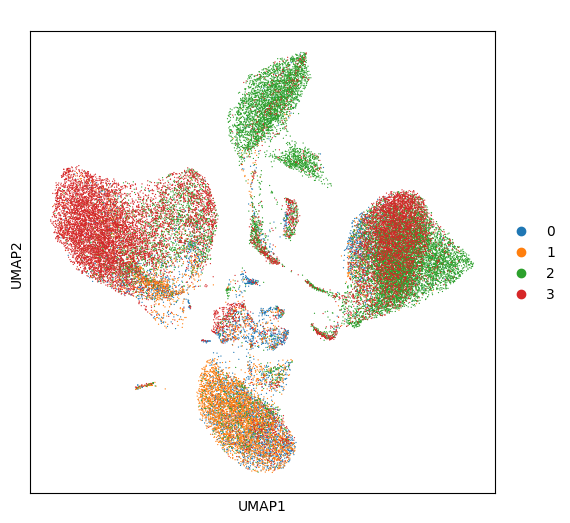

In [10]:
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(adata_all_scanorama, color=['batch'], title=' ', legend_fontsize=10)

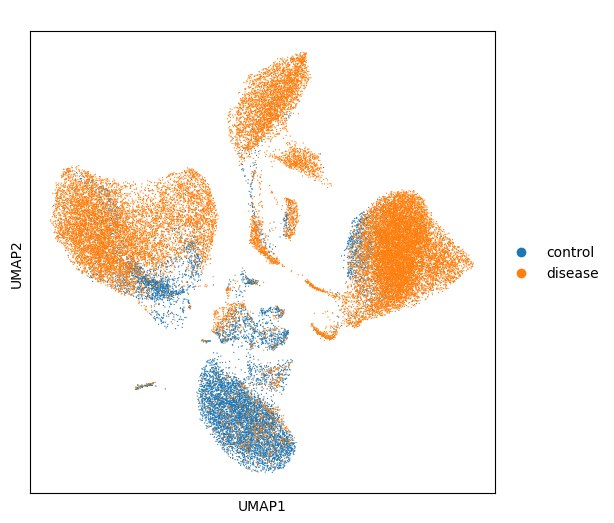

In [13]:
with rc_context({'figure.figsize': (6, 6)}):
    sc.pl.umap(adata_all_scanorama, color=['condition'], title=' ', legend_fontsize=10)

In [14]:
adata_all_scanorama

AnnData object with n_obs × n_vars = 37380 × 22915
    obs: 'condition', 'n_genes', 'prc_mt', 'prc_rb', 'n_counts', 'batch'
    var: 'gene_ids'
    uns: 'neighbors', 'umap', 'batch_colors', 'condition_colors'
    obsm: 'Scanorama', 'X_umap'
    obsp: 'distances', 'connectivities'

### Write integrated dataset to disk

In [15]:
adata_all_scanorama.write_h5ad(
    H5AD_INTEGRATED,
    compression=hdf5plugin.FILTERS["zstd"]
)